In [0]:
#libraries for data processing
import numpy as np
import pandas as pd

#for data importing
from google.cloud import bigquery
import google.auth

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#different
import warnings
warnings.filterwarnings('ignore')
from google.colab import  files

# 1. Connecting to data
Creating bigquery API client for data importing. For the authorisation will be used special service account - the .json keys can be found in the root of repository with name service_key.json.

In [3]:
#please upload the service key to the root directory of the project here.
files.upload()

{}

In [4]:
try:
  bq_client = bigquery.Client.from_service_account_json('./service_key.json')
  print("The client is successfully created!")
except FileNotFoundError: 
  print("Something went wrong, please make sure service key is uploaded on previous step!")

The client is successfully created!


# 2. Reviewing the data and understanding the variables
Collecting the initial piece of data (10k rows) to explore the structure and values of data:

In [5]:
init_query = "SELECT * FROM bigquery-public-data.iowa_liquor_sales.sales LIMIT 1000"
init_df = bq_client.query(init_query).result().to_dataframe()
init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
invoice_and_item_number    1000 non-null object
date                       1000 non-null object
store_number               1000 non-null object
store_name                 1000 non-null object
address                    996 non-null object
city                       996 non-null object
zip_code                   996 non-null object
store_location             918 non-null object
county_number              995 non-null object
county                     995 non-null object
category                   967 non-null object
category_name              966 non-null object
vendor_number              1000 non-null object
vendor_name                1000 non-null object
item_number                1000 non-null object
item_description           1000 non-null object
pack                       1000 non-null int64
bottle_volume_ml           1000 non-null int64
state_bottle_cost          1000 non-null

In [6]:
init_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,S08285200001,2012-10-15,4565,KUM & GO #228 / Sioux city,1925 S LAKEPORT ST,SIOUX CITY,51106,POINT (-96.346548 42.469008),97,Woodbury,1011500,STRAIGHT RYE WHISKIES,255,Wilson Daniels Ltd.,27102,Templeton Rye,6,750,18.08,27.13,30,813.90,22.5,5.94
1,S26172100046,2015-06-15,3385,Sam's Club 8162 / Cedar Rapids,2605 BLAIRS FERRY RD NE,CEDAR RAPIDS,52402,POINT (-91.67969 42.031819),57,Linn,1011500,STRAIGHT RYE WHISKIES,255,Wilson Daniels Ltd.,27102,Templeton Rye,6,750,18.09,27.14,30,814.20,22.5,5.94
2,INV-00049200015,2016-08-31,2512,Hy-Vee Wine and Spirits / Iowa City,1720 Waterfront Dr,Iowa City,52240,POINT (-91.53046300000001 41.642764),52,JOHNSON,1031000,American Vodka,301,FIFTH GENERATION INC,38177,Titos Handmade Vodka,12,1000,11.92,17.88,5,214.56,5.0,1.32
3,S21591000003,2014-10-06,2555,Hy-Vee Food Store / Keokuk,3111 MAIN,KEOKUK,52632,POINT (-91.403752 40.41538),56,Lee,1701100,DECANTERS & SPECIALTY PACKAGES,65,Jim Beam Brands,407,Jim Beam w/3-50mls,6,900,10.49,15.74,6,94.44,5.4,1.43
4,INV-21652100005,2019-09-03,3612,B and C Liquor / Maquoketa,509 E Platt,Maquoketa,52060,POINT (-90.659692 42.06922000000001),49,JACKSON,1701100,Temporary & Specialty Packages,255,Infinium Spirits,100877,Seagrams Extra Smooth w/Lime 50ml,6,2250,10.00,15.00,6,90.00,13.5,3.56


In [7]:
print('\n'.join(list(init_df.columns)))
print('Columns q-ty: ' + str(len(init_df.columns)))

invoice_and_item_number
date
store_number
store_name
address
city
zip_code
store_location
county_number
county
category
category_name
vendor_number
vendor_name
item_number
item_description
pack
bottle_volume_ml
state_bottle_cost
state_bottle_retail
bottles_sold
sale_dollars
volume_sold_liters
volume_sold_gallons
Columns q-ty: 24


Dataset weight in Google Cloud storage - 4.68 GB, so size should be reduced to efficiently download and process it in RAM. 
**invoice_and_item_number** column serves only as unique identifier for each record, so can be removed from analysis.

As per dataset is the timeseries - **date** column will be used as an index.

Mentioned below coumns contains categorical data and can be replaced with synthetic analogs:
* store_number and store_name
* county_number and county
* category and category_name
* vendor_number and vendor_name
* item_number and item_description

Also, next set of columns contains empty values - all of them are categorical,  so can be easily handled during dataset upload:
* address
* city
* zip_code
* store_location
* county_number
* county
* category
* category_name
* vendor_number

Next set of column contain the numerical data: 
* pack - discrete, q-ty of bottles in package
* bottle_volume_ml
* state_bottle_cost - price for buying one bottle
* state_bottle_retail - price for selling one bottle
* bottles_sold
* sale_dollars
* volume_sold_liters
* volume_sold_gallons - needs to be checked with *volume_sold_liters*

**sale_dollars** or **bottles_sold** columns are the dependednt variable, all others are the predictors.

### Looking for overall dataset size and maximum values of columns

In [0]:
data_descr_query = """
SELECT 
    "MAX Values" AS descr,
    MAX(store_number) AS max_store_num,
    MAX(vendor_number) AS max_vendor_num,
    MAX(zip_code) AS max_zip,
    MAX(item_number) AS max_item_num,
    MAX(pack) AS pack_max,
    MAX(bottle_volume_ml) AS volume_max,
    MAX(state_bottle_cost) AS max_bottle_cost,
    MAX(state_bottle_retail) AS max_retail,
    MAX(bottles_sold) AS max_bottles_sold,
    MAX(sale_dollars) AS max_sale_dollars
FROM bigquery-public-data.iowa_liquor_sales.sales
UNION ALL
SELECT 
    "MIN Values" AS descr,
    MIN(store_number) AS max_store_num,
    MIN(vendor_number) AS max_vendor_num,
    MIN(zip_code) AS max_zip,
    MIN(item_number) AS max_item_num,
    MIN(pack) AS pack_max,
    MIN(bottle_volume_ml) AS volume_max,
    MIN(state_bottle_cost) AS max_bottle_cost,
    MIN(state_bottle_retail) AS max_retail,
    MIN(bottles_sold) AS max_bottles_sold,
    MIN(sale_dollars) AS max_sale_dollars
FROM bigquery-public-data.iowa_liquor_sales.sales
"""
overall_count_query = "SELECT COUNT(*) AS overall_count FROM bigquery-public-data.iowa_liquor_sales.sales"

In [0]:
data_descr_df = bq_client.query(data_descr_query).result().to_dataframe()
overall_count = bq_client.query(overall_count_query).result().to_dataframe()

In [10]:
overall_count

,overall_count
0,18098417


In [11]:
data_descr_df

,descr,max_store_num,max_vendor_num,max_zip,max_item_num,pack_max,volume_max,max_bottle_cost,max_retail,max_bottles_sold,max_sale_dollars
0,MIN Values,2106,010,50002,100001,1,0,0.0,0.0,0,0.00
1,MAX Values,9938,987,80904,x904631,336,378000,7680.0,11520.0,15000,279557.28


In [0]:
# specifying data types for data uploading
dtypes = {'pack': np.int16, 'bottle_volume_ml': np.int32, 'state_bottle_cost': np.float32, 
          'state_bottle_retail': np.float32, 'bottles_sold': np.int16, 'zip_code': np.int32,
          'store_number': np.int16, 'vendor_number': np.int16, 'county_number': np.int32}

In [0]:
# creating query for uploading the data with respect to missing values in categorical columns (every missing value should be replaced by unique identifier)
all_items_query = """
SELECT
    date,
    COALESCE(SAFE_CAST(store_number AS NUMERIC), -999) AS store_number,
    COALESCE(address, "NO ADDRESS") AS address,
    COALESCE(city,"NO CITY") AS city,
    COALESCE(SAFE_CAST(zip_code AS NUMERIC), -999) AS zip_code,
    COALESCE(store_location, "LOCATION UMKNOWN") AS store_location,
    COALESCE(SAFE_CAST(county_number AS NUMERIC), -999) AS county_number,
    COALESCE(category, "NO CATEGORY") AS category,
    COALESCE(SAFE_CAST(vendor_number AS NUMERIC), -999) AS vendor_number,
    COALESCE(SAFE_CAST(item_number AS NUMERIC), -999) AS item_number, 
    pack,
    bottle_volume_ml,
    state_bottle_cost,
    state_bottle_retail,
    bottles_sold,
    sale_dollars
FROM bigquery-public-data.iowa_liquor_sales.sales
"""

In [0]:
# if personal drive doesn't mounted to the collab - try to change address variable to your default
# working directory
address = r'./full_dataset.csv'
try:
  all_items_df = pd.read_csv(address, dtype=dtypes)
except FileNotFoundError:
  all_items_df = bq_client.query(all_items_query).result().to_dataframe(dtypes=dtypes)
  try:
    all_items_df.to_csv(address)
  except:
    pass

In [0]:
#changing the default index to datetime index
all_items_df['date'] = pd.to_datetime(all_items_df['date'])
all_items_df.set_index('date', inplace=True)
all_items_df.drop('Unnamed: 0', axis=1, inplace=True)

In [0]:
# specifying function to adjust the view of the numerical columns
format_columns = lambda s: s.apply(lambda x: format(x, '.2f'))

In [17]:
all_items_df.describe().apply(format_columns)

,store_number,zip_code,county_number,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars
count,17926603.00,17926603.00,17926603.00,17926603.00,17926603.00,17926603.00,17926603.00,17926593.00,17926593.00,17926603.00,17926593.00
mean,3655.67,51010.31,48.04,259.03,46622.02,12.29,917.88,9.62,14.93,10.21,133.35
std,1001.58,3779.49,101.98,139.92,56890.78,7.62,675.68,10.45,15.74,27.17,456.02
min,2106.00,-999.00,-999.00,-999.00,-999.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,2612.00,50315.00,31.00,115.00,27025.00,6.00,750.00,5.50,8.25,2.00,31.41
50%,3756.00,51054.00,61.00,260.00,38177.00,12.00,750.00,8.07,12.29,6.00,70.56
75%,4452.00,52302.00,77.00,380.00,64676.00,12.00,1000.00,11.99,17.99,12.00,137.16
max,9938.00,80904.00,99.00,987.00,999449.00,336.00,378000.00,7680.00,11520.00,15000.00,279557.28


In [18]:
categorical = [
               'store_number',
               'address',
               'city','zip_code',
               'store_location',
               'county_number',
               'category',
               'vendor_number',
               'item_number']
all_items_df[categorical].nunique(axis=0)

store_number      2320
address           3577
city               831
zip_code           486
store_location    1868
county_number      100
category           200
vendor_number      332
item_number       9034
dtype: int64

1. All columns except of pack contain zero values - thats pretty strange, suspect the errors in data here.
2. All columns except of pack contains huge outliers - the max value more than two orders of magnitude larger than 75% percentile.
3. For the most values in the dataset mean is much grater than median.

#3. Suggestion about the valuable information that can be presented for business:
1. Market analysis - sales trend, seasonal decomposition for demand planning, split by cities / counties, sales predictions (Holt-Winters, ARIMA, etc.)
2. Existing prices on the market for items, categories, trends and dynamics over time.
3. If to add information about population in the cities - average alcohol consumption for person, cities where demand is higher than proposal (city demand - avg state demand)
4. Competitors analysis - items range for every / most trending vendors, popular items which are not presented in the market, vendor price segment.
5. Cities with low competition - where only few vendors presented (better to match with population info)
6. Trending items by volumes over time.
7. Categorical and vendor marginality

# 4. Cleaning up the dataset

Sale_dollars column should be the product of state_bottle_retail and bottles_sold columns.

In [19]:
all_items_df['synth_sales'] = all_items_df['state_bottle_retail'] * all_items_df['bottles_sold']
print(np.allclose(all_items_df['synth_sales'], all_items_df['sale_dollars'], atol=0.01))

False


Based on evaluation the data in following columns are not similar and there is no way to detect what data are accurate. All inconsistent row should be dropped from the dataset to guaranty the result accuracy. Let's check the q-ty of rows we plan to drop:

In [20]:
# not changing the dataset
all_items_df.query('(sale_dollars - synth_sales) > 0.01 or (sale_dollars - synth_sales) < -0.01', inplace=False).shape

(820998, 16)

In [21]:
# taking a quick look for the differences
all_items_df.query('(sale_dollars - synth_sales) > 0.01 or (sale_dollars - synth_sales) < -0.01', inplace=False).head()

,store_number,address,city,zip_code,store_location,county_number,category,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,synth_sales
date,,,,,,,,,,,,,,,,
2016-08-29,2573,2400 2nd Ave,Muscatine,52761,POINT (-91.035138 41.451349),70,1070000,434,63522,6,800,3.55,5.330000,2,31.98,10.660000
2016-08-31,4452,2825 Gordon Dr,Sioux City,51105,POINT (-96.372014 42.489632),97,1081000,421,64870,48,100,0.89,1.340000,3,64.32,4.020000
2016-08-31,5238,"1923, 5th Ave S",Fort Dodge,50501,POINT (-94.170859 42.501169),94,1070000,395,58835,6,800,4.62,6.930000,3,6.93,20.789999
2016-10-13,2190,1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,NO CATEGORY,420,561,6,850,26.49,39.740002,6,233.82,238.440002
2016-11-08,3650,118 South Main St.,Holstein,51025,POINT (-95.544794 42.488704),47,NO CATEGORY,420,100065,6,800,26.49,39.740002,1,38.96,39.740002


In [0]:
# filtering the rows of the dataset inplace
all_items_df.query('(sale_dollars - synth_sales) < 0.01 and (sale_dollars - synth_sales) > -0.01', inplace=True)

In [0]:
# filtering the rows where sales equal to 0
all_items_df.query('sale_dollars > 0', inplace=True)

In [0]:
# drop the unnecessary columns
all_items_df.drop('synth_sales', axis=1, inplace=True)

In [0]:
all_items_df.dropna(subset=['state_bottle_retail', 'bottles_sold', 'sale_dollars'], inplace=True)

In [0]:
quant_columns = ['pack',
                 'bottle_volume_ml',
                 'state_bottle_cost',
                 'state_bottle_retail',
                 'bottles_sold',
                 'sale_dollars',
                 ]

In [27]:
all_items_df[quant_columns].describe().apply(format_columns)

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars
count,17102510.00,17102510.00,17102510.00,17102510.00,17102510.00,17102510.00
mean,12.32,914.40,9.53,14.71,10.21,131.56
std,7.63,679.71,10.47,15.80,26.19,437.81
min,1.00,0.00,0.19,0.29,1.00,1.34
25%,6.00,750.00,5.48,8.22,2.00,31.00
50%,12.00,750.00,8.00,12.00,6.00,70.56
75%,12.00,1000.00,11.78,17.67,12.00,135.60
max,336.00,378000.00,7680.00,11520.00,11952.00,279557.28


### Investigating outliers
All columns numeric columns here have huge outliers - the difference between maximum and 3 percenile reall great. Lets look what it is and investigate impact.

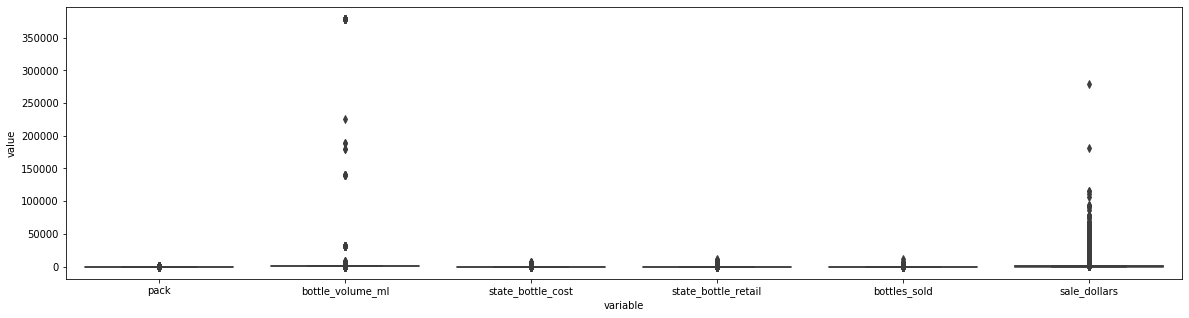

In [28]:
fig = plt.figure(figsize=(20, 5))
sns.boxplot(x='variable', y='value', data=pd.melt(all_items_df[quant_columns]))
fig.show()

In [0]:
# copying the main df to leave the original data unaffected
df = all_items_df.copy()

In [0]:
# calculating the IQR for different columns
# sale_dollars
sales_q1 = all_items_df['sale_dollars'].quantile(0.25)
sales_q3 = all_items_df['sale_dollars'].quantile(0.75)
sales_iqr = sales_q3 - sales_q1

# state_bottle_retail
retail_q1 = all_items_df['state_bottle_retail'].quantile(0.25)
retail_q3 = all_items_df['state_bottle_retail'].quantile(0.75)
retail_iqr = retail_q3 - retail_q1

# bottles_sold
bottles_q1 = all_items_df['bottles_sold'].quantile(0.25)
bottles_q3 = all_items_df['bottles_sold'].quantile(0.75)
bottles_iqr = bottles_q3 - bottles_q1

In [31]:
df.query('@sales_q1 - 1.5* @sales_iqr >= sale_dollars or sale_dollars >= @sales_q3 + 1.5 * @sales_iqr', inplace=False).shape

(1068106, 15)

In [32]:
df.query('@sales_q1 - 1.5* @sales_iqr >= sale_dollars or sale_dollars >= @sales_q3 + 1.5 * @sales_iqr', inplace=False).tail()

,store_number,address,city,zip_code,store_location,county_number,category,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars
date,,,,,,,,,,,,,,,
2018-08-06,5195,"1928, Sherwood Dr",Council Bluffs,51530,POINT (-95.811475 41.278661),78,1022100,395,89191,12,500,11.50,17.25,60,1035.00
2017-11-03,5459,204 6th St,Corning,50841,LOCATION UMKNOWN,2,1022100,395,89191,12,500,11.50,17.25,24,414.00
2017-11-14,5028,"1100, E 5th St",Storm Lake,50588,POINT (-95.186938 42.644563),11,1022100,395,89191,12,500,11.50,17.25,24,414.00
2015-09-08,2607,520 SO FREMONT,SHENANDOAH,51601,POINT (-95.385111 40.761736),73,1081200,305,73051,12,500,8.87,13.31,36,479.16
2012-12-21,2643,2126 KIMBALL AVE,WATERLOO,50701,LOCATION UMKNOWN,7,1081200,305,73051,12,500,8.87,13.31,24,319.44


In [33]:
df.query('@bottles_q1 - 1.5* @bottles_iqr >= bottles_sold or bottles_sold >= @bottles_q3 + 1.5 * @bottles_iqr', inplace=False).shape

(714056, 15)

In [34]:
df.query('@bottles_q1 - 1.5* @bottles_iqr >= bottles_sold or bottles_sold >= @bottles_q3 + 1.5 * @bottles_iqr', inplace=False).head()

,store_number,address,city,zip_code,store_location,county_number,category,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars
date,,,,,,,,,,,,,,,
2018-05-03,2248,3500 Ingersoll Ave,Des Moines,50312,POINT (-93.664182 41.586319),77,1031100,421,38089,48,100,0.89,1.34,48,64.32
2017-11-20,2536,4815 Maple Drive,Pleasant Hill,50317,POINT (-93.519187 41.598109),77,1031100,421,38089,48,100,0.89,1.34,48,64.32
2016-04-19,2665,1005 E HICKMAN RD,WAUKEE,50263,POINT (-93.854477 41.615059),25,1081600,421,64870,48,100,0.89,1.34,336,450.24
2015-12-22,4452,2825 GORDON DR,SIOUX CITY,51105,POINT (-96.372014 42.489632),97,1081600,421,64870,48,100,0.89,1.34,144,192.96
2015-12-21,3963,1925 W BROADWAY,COUNCIL BLUFFS,51501,POINT (-95.873073 41.261866),78,1081600,421,64870,48,100,0.89,1.34,144,192.96


In [35]:
df.query('@retail_q1 - 1.5* @retail_iqr >= state_bottle_retail or state_bottle_retail >= @retail_q3 + 1.5 * @retail_iqr', inplace=False).shape

(850145, 15)

In [36]:
df.query('@retail_q1 - 1.5* @retail_iqr >= state_bottle_retail or state_bottle_retail >= @retail_q3 + 1.5 * @retail_iqr', inplace=False).head()

,store_number,address,city,zip_code,store_location,county_number,category,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars
date,,,,,,,,,,,,,,,
2019-12-10,3981,255 16th St SW,Sioux Center,51250,POINT (-96.179835 43.060881),84,1012200,260,100572,6,800,62.50,93.750000,6,562.50
2017-06-15,2248,3500 Ingersoll Ave,Des Moines,50312,POINT (-93.664182 41.586319),77,1012300,420,464,6,850,23.49,35.240002,12,422.88
2018-12-19,4652,"3107, Brady St",Davenport,52803,POINT (-90.569719 41.55216),82,NO CATEGORY,421,100015,3,3500,30.00,45.000000,2,90.00
2017-11-14,2666,2510 SW State St,Ankeny,50023,POINT (-93.621824 41.705188),77,1701100,420,1025,6,800,23.49,35.240002,90,3171.60
2019-12-17,5444,11 N 3rd Ave,Marshalltown,50158,POINT (-92.908013 42.050021),64,1701100,260,100795,6,850,21.49,32.240002,3,96.72


Looks like the data in the mentioned outliers is pretty consistent, also there are the huge quantity of them. Lets review the impact of removing outliers on the final dataset:

The dataset contains a huge amount of outliers in all numeric columns which looks pretty consistent. Should the outliers be filtered or not depends on the purposes for which dataset planned to be used.

In [0]:
# filtering the dataset from outliers
df.query('@sales_q1 - 1.5* @sales_iqr <= sale_dollars <= @sales_q3 + 1.5 * @sales_iqr', inplace=True)
df.query('@bottles_q1 - 1.5* @bottles_iqr <= bottles_sold <= @bottles_q3 + 1.5 * @bottles_iqr', inplace=True)
df.query('@retail_q1 - 1.5* @retail_iqr <= state_bottle_retail <= @retail_q3 + 1.5 * @retail_iqr', inplace=True)

In [38]:
df.describe().apply(format_columns)

,store_number,zip_code,county_number,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars
count,15067949.00,15067949.00,15067949.00,15067949.00,15067949.00,15067949.00,15067949.00,15067949.00,15067949.00,15067949.00,15067949.00
mean,3659.15,51044.22,48.31,258.53,45565.59,12.26,897.32,8.52,12.82,7.08,80.95
std,989.56,3548.01,99.27,139.77,43759.13,6.83,466.91,4.16,6.20,5.67,64.83
min,2106.00,-999.00,-999.00,-999.00,-999.00,1.00,0.00,0.59,0.88,1.00,1.34
25%,2612.00,50315.00,31.00,115.00,28086.00,6.00,750.00,5.38,8.07,2.00,27.72
50%,3769.00,51058.00,60.00,260.00,39866.00,12.00,750.00,7.60,11.40,6.00,64.56
75%,4448.00,52302.00,77.00,380.00,62369.00,12.00,1000.00,10.99,16.49,12.00,117.48
max,9927.00,57222.00,99.00,987.00,999292.00,288.00,9000.00,30.00,31.83,27.00,292.50


In [0]:
# evaluating the impact of outliers elimination
sales_monthly = pd.DataFrame(df['sale_dollars'].groupby(pd.Grouper(freq='M')).sum())
sales_monthly['all_sales'] = all_items_df['sale_dollars'].groupby(pd.Grouper(freq='M')).sum()

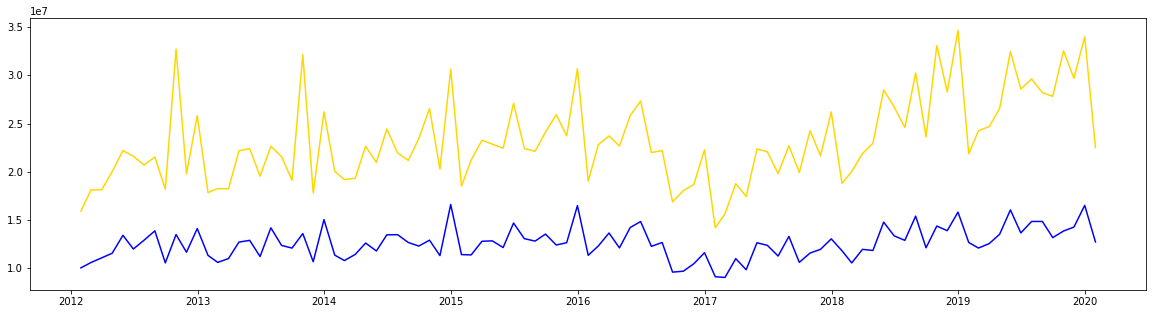

In [40]:
fig = plt.figure(figsize=(20, 5))
plt.plot(sales_monthly.index, sales_monthly.sale_dollars, color='blue')
plt.plot(sales_monthly.index, sales_monthly.all_sales, color='gold')
fig.show()

The figure above shows:
1. Strong seasonal patern in original dataset
2. Sales ammount is on positive trend
3. Timeseries is unstationary, so it should be normalized for further processing
4. Outliers, removed from the dataset makes up an important part of sales so can't be easily excluded
5. The most differences is in the seasonal peaks - investigation of this point can show which costly alco items are trendy in the specific season
6. Line which include all items growth faster than filtered - it can means that consumption of high price drinks grows, or people prefer to by it by bigger groups.

# 5. Looking for relations in data

### Cheking up the original data

In [0]:
corr_df = all_items_df.corr()

In [42]:
corr_df

,store_number,zip_code,county_number,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars
store_number,1.000000,-0.017767,-0.037916,-0.000544,-0.022989,0.107284,-0.059925,-0.046998,-0.047232,0.006470,-0.026241
zip_code,-0.017767,1.000000,0.588696,0.001093,0.001159,-0.004656,0.003983,0.000693,0.000728,0.000519,-0.000564
county_number,-0.037916,0.588696,1.000000,0.000201,0.002721,-0.006469,0.000576,0.005093,0.005142,0.005845,0.006042
vendor_number,-0.000544,0.001093,0.000201,1.000000,0.126100,-0.043165,0.018487,-0.000555,-0.000826,0.009725,-0.007901
item_number,-0.022989,0.001159,0.002721,0.126100,1.000000,-0.022676,-0.022679,0.086304,0.086172,0.018725,0.025121
pack,0.107284,-0.004656,-0.006469,-0.043165,-0.022676,1.000000,-0.446527,-0.251535,-0.251929,0.128027,-0.049512
bottle_volume_ml,-0.059925,0.003983,0.000576,0.018487,-0.022679,-0.446527,1.000000,0.459605,0.459969,-0.014233,0.066640
state_bottle_cost,-0.046998,0.000693,0.005093,-0.000555,0.086304,-0.251535,0.459605,1.000000,0.999978,-0.041502,0.104788
state_bottle_retail,-0.047232,0.000728,0.005142,-0.000826,0.086172,-0.251929,0.459969,0.999978,1.000000,-0.041496,0.104838
bottles_sold,0.006470,0.000519,0.005845,0.009725,0.018725,0.128027,-0.014233,-0.041502,-0.041496,1.000000,0.824695


In [0]:
mask = np.zeros_like(corr_df.values)
mask[np.triu_indices_from(mask)] = True

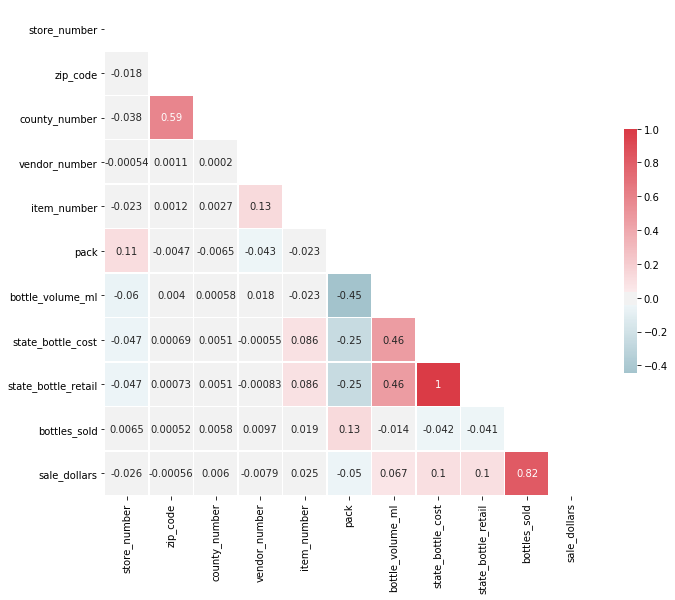

In [44]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, mask=mask)
f.show()

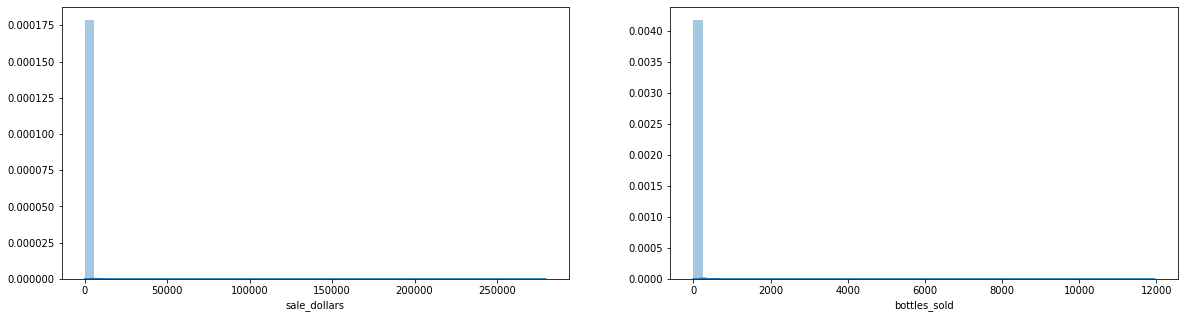

In [45]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.distplot(all_items_df.sale_dollars)
plt.subplot(1, 2, 2)
sns.distplot(all_items_df.bottles_sold)
fig.show()

The original data is totaly skewed and conatians huge outliers

### Checking up the filtered data

In [0]:
corr_df = df.corr()

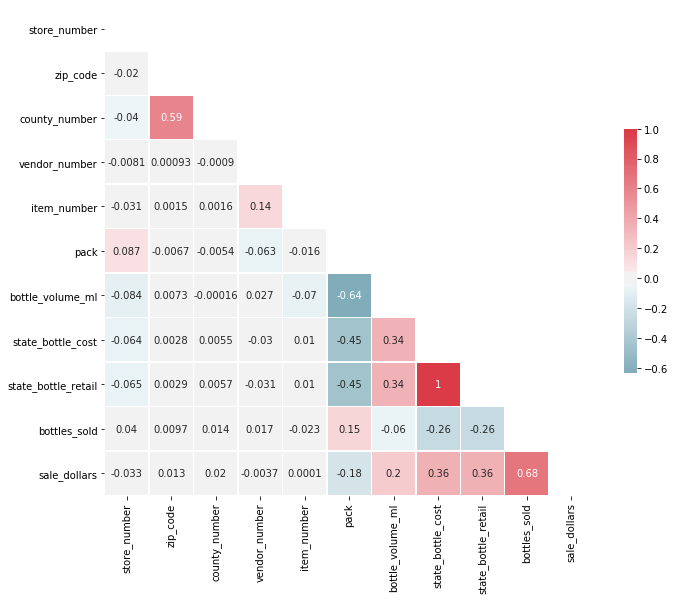

In [47]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, mask=mask)
f.show()

And here is few interesting correlations:
1. First thing - strong negative correlation between bottle volume and q-ty of bottles in pack
2. Also there in negative correlation between bottle cost and q-ty in pack.

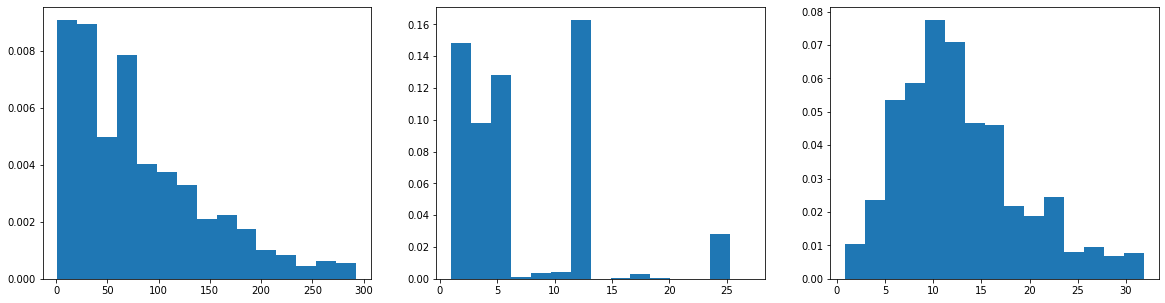

In [76]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(df.sale_dollars, bins=15, normed=True)
plt.subplot(1, 3, 2)
plt.hist(df.bottles_sold, bins=15, normed=True)
plt.subplot(1, 3, 3)
plt.hist(df.state_bottle_retail, bins=15, normed=True)
fig.show()

Distribution of both dependent variables are skewed, in case of bottles - bimodal. Retail cost distributed close to normal, but also skewed.